## Neural Style Transfer

In [ ]:
!pip install -q torch_snippets
import torch
import torch.nn as nn
import torch.optim as optim
from torch_snippets import *
from torchvision import transforms as T
from torch.nn import functional as F
from torchvision.models import vgg19
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
preprocess = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.Lambda(lambda x: x.mul_(255))
])
postprocess = T.Compose([
    T.Lambda(lambda x: x.mul_(1./255)),
    T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])
])

In [ ]:
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        feat = input.view(b,c,h*w)
        G = feat@feat.transpose(1,2)
        return G.div_(h*w)

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = F.mse_loss(GramMatrix()(input), target)
        return out

class vgg19_modified(nn.Module):
    def __init__(self):
        super().__init__()
        features = list(vgg19(pretrained = True).features)
        self.features = nn.ModuleList(features).eval()
    def forward(self, x, layers=[]):
        order = np.argsort(layers)
        _results, results = [], []
        for i, model in enumerate(self.features):
            x = model(x)
            if i in layers:
                _results.append(x)
        for i in order:
            results.append(_results[i])
        return results if layers is not [] else x

In [ ]:
vgg = vgg19_modified().to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 76.5MB/s]


In [ ]:
imgs = [Image.open(path).resize((512,512)).convert('RGB') for path in ['rainbow.png', 'poico.png']]
style_image, content_image = [preprocess(img).to(device)[None] for img in imgs]

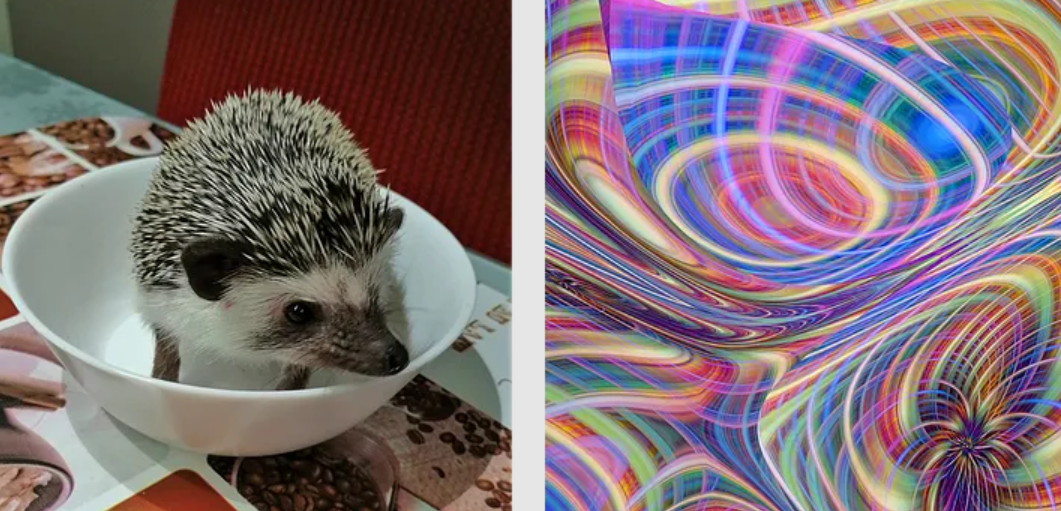

In [ ]:
opt_img = content_image.data.clone()
opt_img.require_grad = True

In [ ]:
style_layers = [0,5,10,19,28]
content_layers = [21]
loss_layers = style_layers + content_layers

In [ ]:
loss_fns = [GramMSELoss()]*len(style_layers) + [nn.MSELoss()]*len(content_layers)
loss_fns = [loss_fn.to(device) for loss_fn in loss_fns]

In [ ]:
style_weight = [1000/n**2 for n in [64,128,256,512,512]]
content_weight = [1]
weight = style_weight + content_weight

In [ ]:
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets

In [ ]:
max_iters = 500
optimizer = optim.LBFGS([opt_img])

In [ ]:
iters = 0
while iters < max_iters:
    def closure():
        global iters
        iters += 1
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = [weight[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        return loss
    optimizer.step(closure)

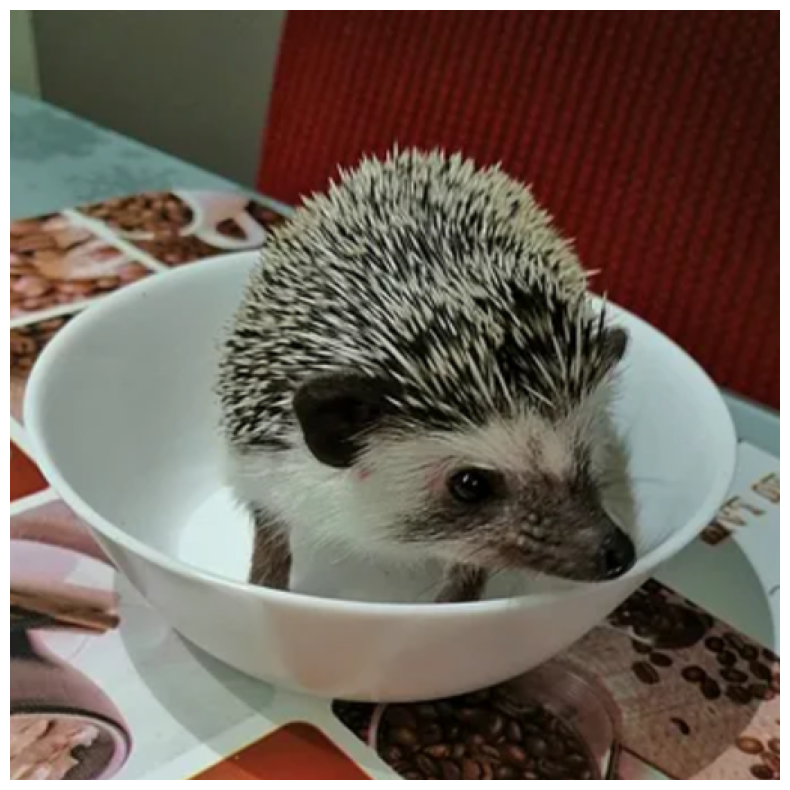

In [ ]:
with torch.no_grad():
    out_img = postprocess(opt_img[0]).permute(1,2,0)
show(out_img)

# Tensores

In [ ]:
import torch
sample = torch.tensor([1.0, 2.0, 3.0])
print(sample.shape)

torch.Size([3])


In [ ]:
x = torch.tensor([[1.0, 2.0], [3.0, 4.0]])
print(x.shape)

torch.Size([2, 2])


In [ ]:
y = torch.tensor([[[1.0, 2.0], [3.0, 4.0]], [[5.0, 6.0], [7.0, 8.0]]])
print(y.shape)

torch.Size([2, 2, 2])


In [ ]:
import torch
import plotly.graph_objs as go
import plotly.offline as pyo

a = torch.tensor([[[1,2], [2,3], [3,4], [4,5]]])
x_vals = []
y_vals = []
z_vals = []

for i in range(a.shape[0]):
    for j in range(a.shape[1]):
        for k in range(a.shape[2]):
            x_vals.append(i)
            y_vals.append(j)
            z_vals.append(k)

trace = go.Scatter3d(
    x=x_vals,
    y=y_vals,
    z=z_vals,
    mode='markers',
    marker=dict(
        size=5,
        color='blue',
        opacity=0.8,
        colorscale='Viridis'
    )
)

layout = go.Layout(
    scene=dict(
        xaxis=dict(title='Axis X'),
        yaxis=dict(title='Axis Y'),
        zaxis=dict(title='Axis Z')
    )
)

fig = go.Figure(data=[trace], layout=layout)
pyo.plot(fig, filename='tensor.html')

'tensor.html'

## Operações com tensores

In [ ]:
import torch

# Criando tensores
a = torch.tensor([1, 2, 3])
b = torch.tensor([4, 5, 6])

# Adição
soma = a + b
print("Soma:", soma)  # tensor([5, 7, 9])

# Multiplicação elemento a elemento
produto = a * b
print("Produto:", produto)  # tensor([4, 10, 18])

Soma: tensor([5, 7, 9])
Produto: tensor([ 4, 10, 18])


In [ ]:
# Produto escalar
dot_product = torch.dot(a, b)
print("Produto escalar:", dot_product)  # tensor(32)

Produto escalar: tensor(32)


In [ ]:
# Multiplicação matricial
matriz_a = torch.randn(2, 3)
matriz_b = torch.randn(3, 2)
matmul = torch.matmul(matriz_a, matriz_b)
print("Multiplicação matricial:\n", matmul)

Multiplicação matricial:
 tensor([[-0.3755, -0.6426],
        [-0.5650,  0.1760]])


In [ ]:
# Comparação elemento a elemento
maior_que = a > 2
print("Elementos > 2:", maior_que)  # tensor([False, False, True])

Elementos > 2: tensor([False, False,  True])


In [ ]:
# Operação AND lógico
x = torch.tensor([True, False, True])
y = torch.tensor([False, False, True])
logical_and = x & y
print("AND lógico:", logical_and)  # tensor([False, False, True])

AND lógico: tensor([False, False,  True])


In [ ]:
# Máscara booleana
mask = torch.tensor([True, False, True])
result = a[mask]
print("Máscara booleana:", result)  # tensor([1, 3])

Máscara booleana: tensor([1, 3])


In [ ]:
# Concatenação vertical (ao longo da dimensão 0)
concat_v = torch.cat([a.unsqueeze(0), b.unsqueeze(0)], dim=0)
print("Concatenação vertical:\n", concat_v)

Concatenação vertical:
 tensor([[1, 2, 3],
        [4, 5, 6]])


In [ ]:
# Concatenação horizontal (ao longo da dimensão 1)
concat_h = torch.cat([a.unsqueeze(1), b.unsqueeze(1)], dim=1)
print("Concatenação horizontal:\n", concat_h)

Concatenação horizontal:
 tensor([[1, 4],
        [2, 5],
        [3, 6]])


In [ ]:
# Empilhamento (stack)
stacked = torch.stack([a, b])
print("Empilhamento:\n", stacked)

Empilhamento:
 tensor([[1, 2, 3],
        [4, 5, 6]])


In [ ]:
# Criando um tensor 3D
tensor_3d = torch.randn(2, 3, 4)
print("Tensor original shape:", tensor_3d.shape)

Tensor original shape: torch.Size([2, 3, 4])


In [ ]:
# Permutando dimensões
permuted = tensor_3d.permute(2, 0, 1)
print("Tensor permutado shape:", permuted.shape)

Tensor permutado shape: torch.Size([4, 2, 3])


In [ ]:
# Redimensionamento (reshape)
reshaped = tensor_3d.view(6, 4)
print("Tensor redimensionado shape:", reshaped.shape)

Tensor redimensionado shape: torch.Size([6, 4])


In [ ]:
# Achatar o tensor (flatten)
flattened = tensor_3d.flatten()
print("Tensor achatado shape:", flattened.shape)

Tensor achatado shape: torch.Size([24])


In [ ]:
# Transposição
matrix = torch.randn(3, 5)
transposed = matrix.T
print("Original shape:", matrix.shape, "Transposto shape:", transposed.shape)

Original shape: torch.Size([3, 5]) Transposto shape: torch.Size([5, 3])


# teste

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
'''for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''


"for dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mistag/arthropod-taxonomy-orders-object-detection-dataset")

print("Path to dataset files:", path)



100%|██████████| 11.1G/11.1G [08:48<00:00, 22.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mistag/arthropod-taxonomy-orders-object-detection-dataset/versions/6


In [7]:
!ls
!mv /root/.cache/kagglehub/datasets/mistag/arthropod-taxonomy-orders-object-detection-dataset/versions/6 /content


sample_data


In [10]:
BASE_PATH = '/content/6/ArTaxOr/'

In [11]:
image=[]
labels=[]
for file in os.listdir(BASE_PATH):
    if file=='Coleoptera':
        for c in os.listdir(os.path.join(BASE_PATH, file)):
            if c!='annotations':
                image.append(c)
                labels.append('Coleoptera')
    if file=='Diptera':
        for c in os.listdir(os.path.join(BASE_PATH, file)):
            if c!='annotations':
                image.append(c)
                labels.append('Diptera')
    if file=='Hymenoptera':
        for c in os.listdir(os.path.join(BASE_PATH, file)):
            if c!='annotations':
                image.append(c)
                labels.append('Hymenoptera')
    if file=='Lepidoptera':
        for c in os.listdir(os.path.join(BASE_PATH, file)):
            if c!='annotations':
                image.append(c)
                labels.append('Lepidoptera')
data = {'Images':image, 'labels':labels}
data = pd.DataFrame(data)
data.head()


,Images,labels
0,032123dad6f8.jpg,Diptera
1,8a425c3c3c4e.jpg,Diptera
2,7932d1c1959f.jpg,Diptera
3,90c9d190dda9.jpg,Diptera
4,16302280e2ce.jpg,Diptera


In [12]:
lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])
data.head()

,Images,labels,encoded_labels
0,032123dad6f8.jpg,Diptera,1
1,8a425c3c3c4e.jpg,Diptera,1
2,7932d1c1959f.jpg,Diptera,1
3,90c9d190dda9.jpg,Diptera,1
4,16302280e2ce.jpg,Diptera,1


In [13]:
batch_size = 128
validation_split = .3
shuffle_dataset = True
random_seed= 42

In [14]:
dataset_size = len(data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

In [15]:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [16]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [17]:
class Arthopod_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = Image.open(img_name)
        #image = image.convert('RGB')
        image = image.resize((300,300))
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [18]:
dataset = Arthopod_Dataset(data,BASE_PATH,transform)


In [19]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [20]:
def img_display(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

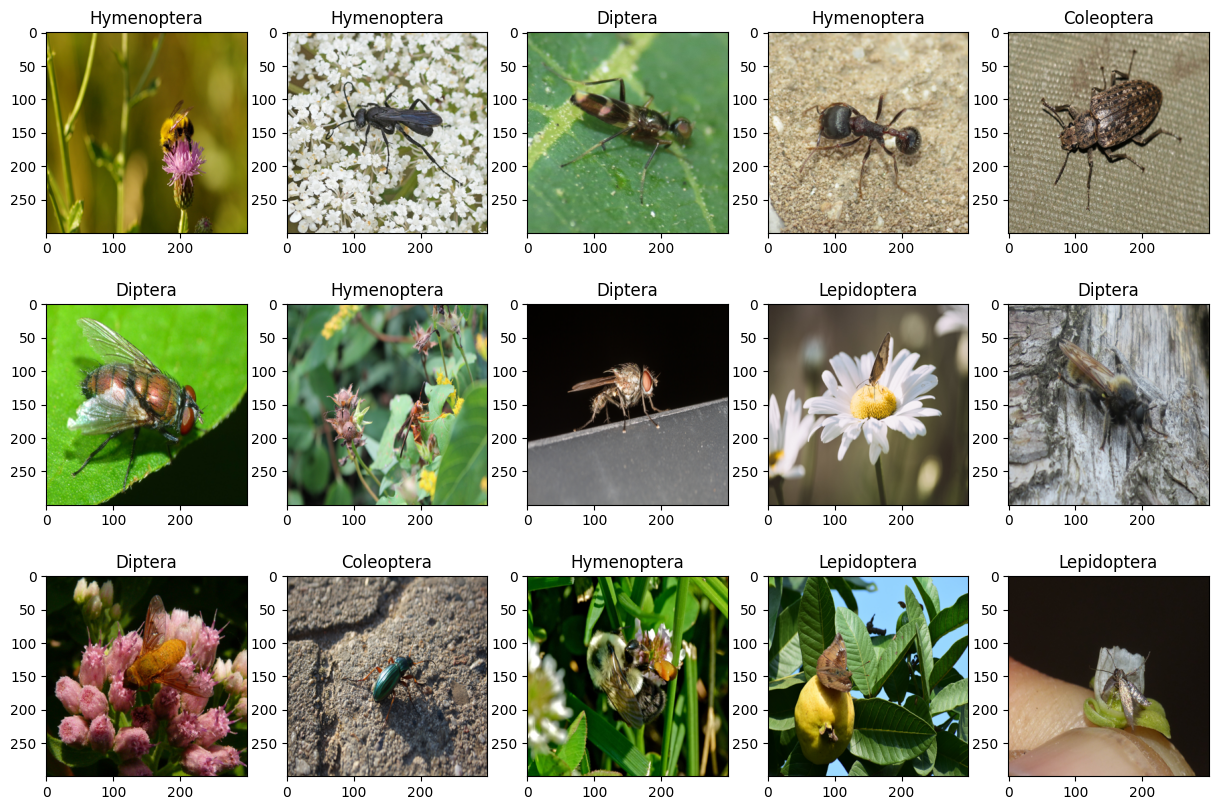

In [22]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
arthopod_types = {0: 'Coleoptera', 1: 'Diptera', 2: 'Hymenoptera', 3: 'Lepidoptera'}
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(img_display(image))
        ax.set(title = f"{arthopod_types[label.item()]}")

In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channel, 16 output channels, 3x3 square convolution kernel
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,stride=2,padding=1)
        self.conv2 = nn.Conv2d(16, 32,kernel_size=3,stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64,kernel_size=3,stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 64,kernel_size=3,stride=2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(0.4)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*5*5,512 )
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 4)

    def forward(self, x):
        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.dropout(self.batchnorm2(self.pool(x)))
        x = self.batchnorm3(self.pool(F.relu(self.conv3(x))))
        x = self.dropout(self.conv4(x))
        x = x.view(-1, 64*5*5) # Flatten layer
        x = self.dropout(self.fc1(x))
        x = self.dropout(self.fc2(x))
        x = F.log_softmax(self.fc3(x),dim = 1)
        return x

In [24]:
#model = Net() # On CPU
model = Net().to(device)  # On GPU
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.4, inplace=False)
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1600, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
)


In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [26]:
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [28]:
n_epochs = 6
print_every = 4
valid_loss_min = np.inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    # scheduler.step(epoch)
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        #data_, target_ = data_.to(device), target_.to(device)# on GPU
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (validation_loader):
            #data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t / total_t)
        val_loss.append(batch_loss/len(validation_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
        # Saving the best weight
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'model_classification_tutorial.pt')
            print('Detected network improvement, saving current model')
    model.train()

Epoch 1



RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot( train_loss, label='train')
plt.plot( val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

In [ ]:
model.load_state_dict(torch.load('model_classification_tutorial.pt'))


In [ ]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
arthopod_types = {0: 'Coleoptera', 1: 'Diptera', 2: 'Hymenoptera', 3: 'Lepidoptera'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
with torch.no_grad():
    model.eval()
    for ax, image, label in zip(axis.flat,images, labels):
        ax.imshow(img_display(image)) # add image
        image_tensor = image.unsqueeze_(0)
        output_ = model(image_tensor)
        output_ = output_.argmax()
        k = output_.item()==label.item()
        ax.set_title(str(arthopod_types[label.item()])+":" +str(k)) # add label